# Project name - Classification

## Problem definition
> Insert here your problem description

## Data
Explain the dataset, how all files are composed and the description of each column

## Evaluation
Explain the evaluation metric that you want to use to evaluate the model. Specify the goal in terms of evaluation metric

### What it will be covered
1. Import of common libraries
2. Data ingestion & cleaning
3. Data Analysis and visualization
4. Feature Selection
5. ML model selection
6. ML model tuning
7. Results visualizations
8. Model export
9. Python and html generation

#### Assumptions
* Data is provided with a single csv file with a header representing the columns'names

### Parameters

In [153]:
INPUT_DATA_FILE = 'data/part-00000'
INSTALL_LIBRARIES = False
REMOVE_ROWS_WITH_INVALID_COLS = True #if False then a SimpleImputer will be used
MATPLOT_STYLE = 'seaborn-dark-palette'
TARGET_COLUMN = 'peopleInHouse'
#if different from None it represents the number of wanted features in the feature selection step
NUM_FEATURES = 5

columns_to_remove =['timestamp','data_2','id','data_3','timestamp_2']

#not include the target in this list
column_to_visualize = ['current','power','co2','external_humidity','internal_humidity','external_temperature','internal_temperature','light_value','tvoc']

column_names_and_types= {
         'data': 'datetime64',
         'current': 'float64',
         'power': 'float64',
         'co2': 'float64',
         'weather': 'str',
         'external_humidity' : 'float64',
         'internal_humidity' : 'float64',
         'external_temperature' : 'float64',
         'internal_temperature' : 'float64',
         'light_value' : 'float64',
         'sunrise' : 'str',
         'sunset' : 'str',
         'tvoc' : 'float64',
         'peopleInHouse' : 'int64'}

#this manage eventually data errors in the dataset using coerce
numeric_features = ['co2','external_humidity','internal_humidity','external_temperature','internal_temperature','tvoc']
datetime_features = ['data']

### 1-Import of common libraries

In [154]:
if INSTALL_LIBRARIES:
    import sys
    !conda install --yes --prefix {sys.prefix} matplotlib
    !conda install --yes --prefix {sys.prefix} numpy
    !conda install --yes --prefix {sys.prefix} pandas
    !conda install --yes --prefix {sys.prefix} scikit-learn
    !conda install --yes --prefix {sys.prefix} ipython
    !conda install --yes --prefix {sys.prefix} seaborn

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from sklearn import metrics
from IPython.display import display
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

%matplotlib inline



plt.style.use(MATPLOT_STYLE)
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (26, 20),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

### 2-Data ingestion & cleaning

In [155]:
raw_input_df = pd.read_csv(INPUT_DATA_FILE, infer_datetime_format=True, index_col=False, skipinitialspace=True)

In [156]:
#Here insert needed specific data cleaning and transformation steps

raw_input_df['external_humidity'] = raw_input_df['external_humidity'].str.rstrip('%')
raw_input_df['internal_humidity'] = raw_input_df['internal_humidity'].str.rstrip('%')
raw_input_df['external_temperature'] = raw_input_df['external_temperature'].str.rstrip('*C')
raw_input_df['internal_temperature'] = raw_input_df['internal_temperature'].str.rstrip('*C')


raw_input_df[datetime_features] = raw_input_df[datetime_features].apply(pd.to_datetime, format='%Y/%m/%d %H:%M')
def labelRow(row):
    weekno = row['data'].weekday()

    if weekno>=5:
        return -1 #it is a weekend

    h = row['data'].hour
    if (h >= 19 and h <= 21) or (h >= 7 and h <= 9):
        return 1
    elif h >= 3 and h <= 5:
        return 0
    else:
        return -1

raw_input_df['peopleInHouse'] = raw_input_df.apply(labelRow, axis=1)
raw_input_df.drop(raw_input_df[raw_input_df.peopleInHouse == -1].index, inplace=True)

In [157]:
raw_input_df = raw_input_df.drop(columns=columns_to_remove)

raw_input_df[numeric_features] = raw_input_df[numeric_features].apply(pd.to_numeric, errors='coerce')
raw_input_df= raw_input_df.astype(column_names_and_types, copy=False, errors='ignore')
raw_input_df[datetime_features] = raw_input_df[datetime_features].apply(pd.to_datetime, format='%Y/%m/%d %H:%M')

if REMOVE_ROWS_WITH_INVALID_COLS:
    raw_input_df = raw_input_df.dropna()
else:
    #TODO: simpleimpute numerical values
    pass

display(raw_input_df.head())
display(raw_input_df.describe())
display(raw_input_df.info())

,data,current,power,co2,weather,external_humidity,internal_humidity,external_temperature,internal_temperature,light_value,sunrise,sunset,tvoc,peopleInHouse
78,2019-12-02 07:57:00,0.23,53.40,400.8,Mostly Cloudy,99.0,59.0,1.0,20.0,3969.0,7:49 am,4:48 pm,0.0,1
79,2019-12-02 07:57:00,0.23,53.96,400.8,Mostly Cloudy,99.0,59.0,1.0,20.0,3969.0,7:49 am,4:48 pm,0.0,1
80,2019-12-02 07:57:00,0.22,50.97,400.8,Mostly Cloudy,99.0,59.0,1.0,20.0,3969.0,7:49 am,4:48 pm,0.0,1
81,2019-12-02 07:57:00,0.25,56.88,400.8,Mostly Cloudy,99.0,59.0,1.0,20.0,3969.0,7:49 am,4:48 pm,0.0,1
82,2019-12-02 07:57:00,0.22,51.58,400.8,Mostly Cloudy,99.0,59.0,1.0,20.0,3969.0,7:49 am,4:48 pm,0.0,1


,current,power,co2,external_humidity,internal_humidity,external_temperature,internal_temperature,light_value,tvoc,peopleInHouse
count,35910.000000,35910.000000,35910.000000,35910.000000,35910.000000,35910.000000,35910.000000,35910.000000,35910.000000,35910.000000
mean,0.550281,126.555902,402.728928,91.769841,63.078084,7.224589,19.516792,51738.264467,0.798636,0.701532
std,1.161170,267.072747,5.627697,10.335435,3.951441,4.114643,0.937481,58864.620690,4.285417,0.457592
min,0.130000,29.740000,400.000000,49.000000,0.000000,-2.000000,0.000000,120.000000,0.000000,0.000000
25%,0.230000,52.842500,400.700000,90.000000,62.000000,5.000000,19.000000,1145.000000,0.000000,0.000000
50%,0.320000,73.245000,401.500000,95.000000,63.000000,7.000000,19.000000,2600.000000,0.000000,1.000000
75%,0.500000,114.387500,403.000000,99.000000,64.000000,8.000000,20.000000,117016.000000,1.000000,1.000000
max,13.120000,3018.620000,538.200000,100.000000,159.000000,22.000000,22.000000,318542.000000,210.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35910 entries, 78 to 401746
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   data                  35910 non-null  datetime64[ns]
 1   current               35910 non-null  float64       
 2   power                 35910 non-null  float64       
 3   co2                   35910 non-null  float64       
 4   weather               35910 non-null  object        
 5   external_humidity     35910 non-null  float64       
 6   internal_humidity     35910 non-null  float64       
 7   external_temperature  35910 non-null  float64       
 8   internal_temperature  35910 non-null  float64       
 9   light_value           35910 non-null  float64       
 10  sunrise               35910 non-null  object        
 11  sunset                35910 non-null  object        
 12  tvoc                  35910 non-null  float64       
 13  peopleInHouse 

None

### 3-Data Analysis and visualization

In [158]:
input_features = column_to_visualize
column_to_visualize.append(TARGET_COLUMN)

plt.figure(figsize=(20,15))
sns.pairplot(raw_input_df[column_to_visualize], kind="reg", hue=TARGET_COLUMN, corner=True, diag_kind="kde", height=16)
plt.suptitle('Pair Plot Features', size = 28);

<Figure size 1440x1080 with 0 Axes>

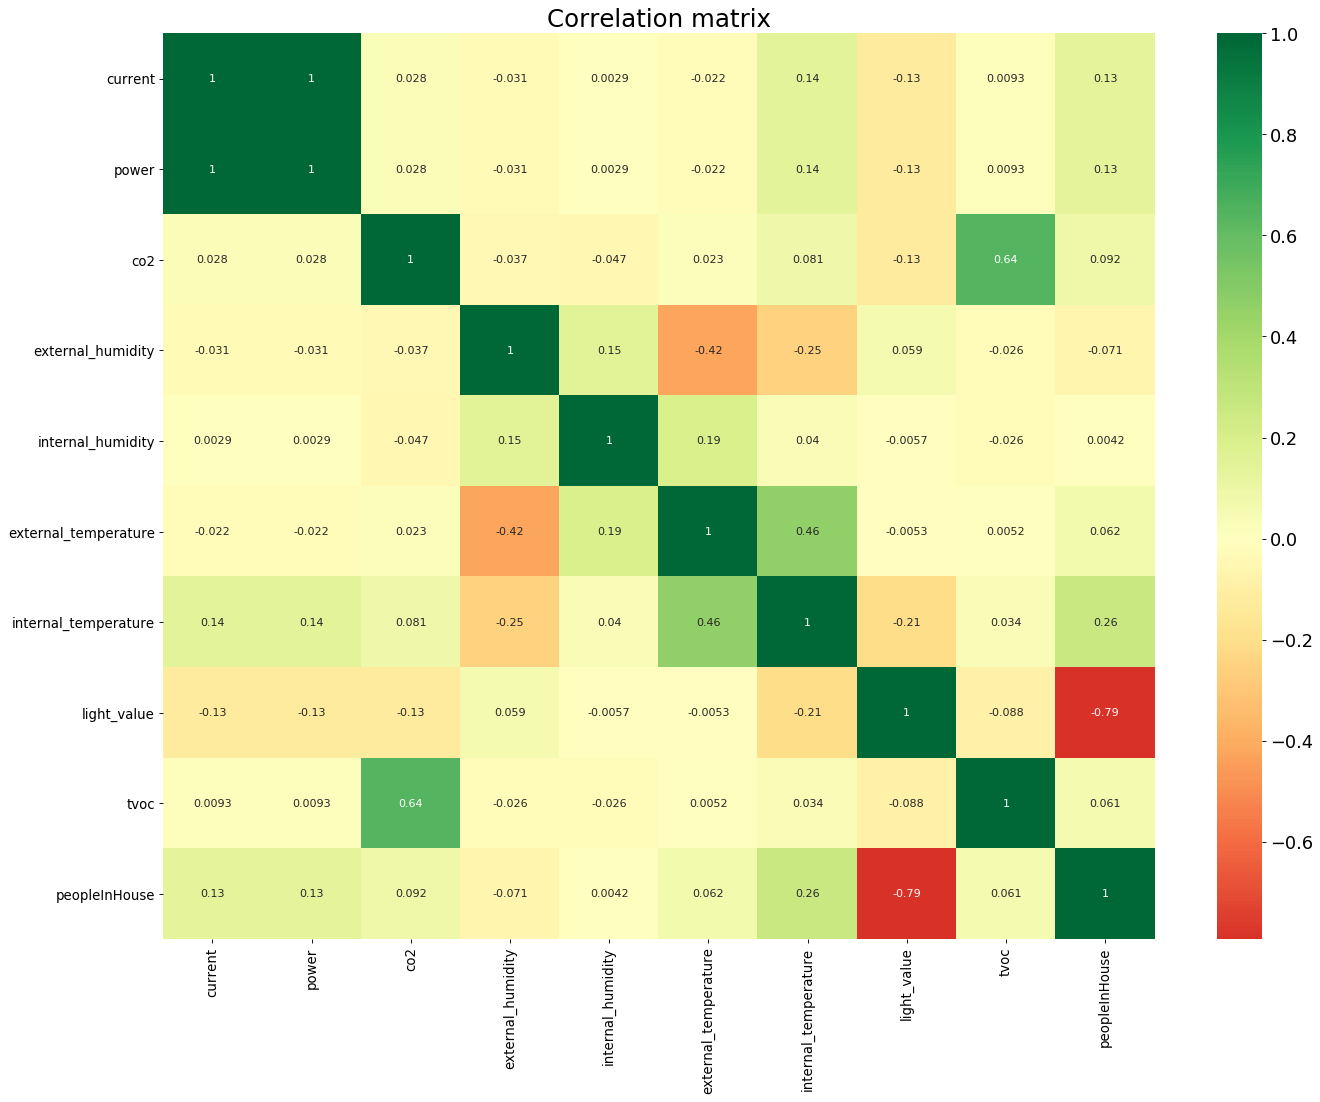

In [159]:
plt.figure(figsize=(20,15), dpi= 80)
sns.heatmap(raw_input_df[column_to_visualize].corr(), xticklabels=raw_input_df[column_to_visualize].corr().columns, yticklabels=raw_input_df[column_to_visualize].corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlation matrix', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

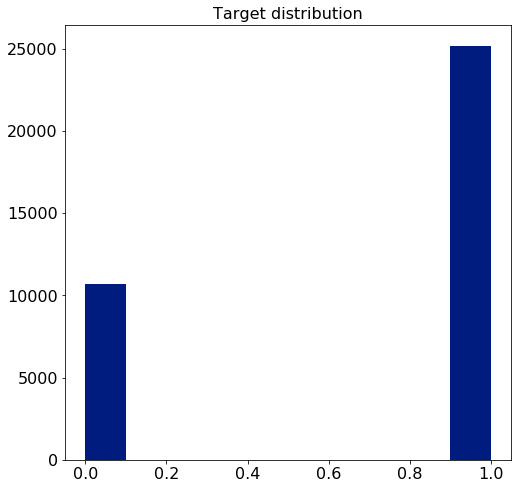

In [170]:
raw_input_df[TARGET_COLUMN].plot(kind='hist', subplots=True, figsize=(8, 8))
plt.title("Target distribution")
plt.ylabel("")
plt.show()

### 4-Feature Selection

In [177]:
if NUM_FEATURES and NUM_FEATURES <= len(input_features):
    feature_names = list(raw_input_df.columns.values)
    
    # Create and fit selector
    select_k_best_classifier = SelectKBest(f_classif, k=NUM_FEATURES)
    fit_transofrmed_features = select_k_best_classifier.fit_transform(raw_input_df[input_features], raw_input_df[TARGET_COLUMN])
    
    mask = select_k_best_classifier.get_support() #list of booleans
    new_features = [] # The list of your K best features

    for bool, feature in zip(mask, feature_names):
        if bool:
            new_features.append(feature)
            
    print("Selected features are: %s" % new_features)
    input_df_reduced = pd.DataFrame(fit_transofrmed_features, columns=new_features)
    input_df_reduced[TARGET_COLUMN] = raw_input_df[TARGET_COLUMN].to_numpy()
    display(input_df_reduced.head())
    display(input_df_reduced.describe())
    display(input_df_reduced.info())

Selected features are: ['data', 'current', 'internal_humidity', 'external_temperature', 'light_value']


D:\Anaconda\envs\ztm_ml_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


,data,current,internal_humidity,external_temperature,light_value,peopleInHouse
0,0.23,53.40,20.0,3969.0,1.0,1
1,0.23,53.96,20.0,3969.0,1.0,1
2,0.22,50.97,20.0,3969.0,1.0,1
3,0.25,56.88,20.0,3969.0,1.0,1
4,0.22,51.58,20.0,3969.0,1.0,1


,data,current,internal_humidity,external_temperature,light_value,peopleInHouse
count,35910.000000,35910.000000,35910.000000,35910.000000,35910.000000,35910.000000
mean,0.550281,126.555902,19.516792,51738.264467,0.701532,0.701532
std,1.161170,267.072747,0.937481,58864.620690,0.457592,0.457592
min,0.130000,29.740000,0.000000,120.000000,0.000000,0.000000
25%,0.230000,52.842500,19.000000,1145.000000,0.000000,0.000000
50%,0.320000,73.245000,19.000000,2600.000000,1.000000,1.000000
75%,0.500000,114.387500,20.000000,117016.000000,1.000000,1.000000
max,13.120000,3018.620000,22.000000,318542.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35910 entries, 0 to 35909
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   data                  35910 non-null  float64
 1   current               35910 non-null  float64
 2   internal_humidity     35910 non-null  float64
 3   external_temperature  35910 non-null  float64
 4   light_value           35910 non-null  float64
 5   peopleInHouse         35910 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.6 MB


None

### 5-ML model selection